In [1]:
library("Mfuzz")
library(ggpubr)
o<-function(w,h) options(repr.plot.width=w, repr.plot.height=h)

mFuzz.ggplot <- function(data, clustering, 
                         centre = TRUE, sort.columns = TRUE,
                         given.order=NA,nrow=2, ncol=4
                        ) {
    # from https://github.com/jspaezp/mFuzzOptim/blob/master/ggMfuzzplot.R    
    require(ggplot2)
    require(dplyr)
    require(tidyr)
    
    clusterindex <- clustering$cluster
    
    # data frame with Membership values
    memship <- clustering$membership 
    colnames(memship) <- paste("membership", 
        seq_along(memship[1,]), 
        sep = ("")) 
    
    exp <- exprs(data)
    
    # This chunk replaces col names by numbers if 
    # more than 1 is character only 
    # or when sort.columns is FALSE
    
    all.char.cols <- !grepl("\\d", colnames(exp))
    if ((sum(all.char.cols) > 1) | !sort.columns) {
        colnames(exp) <- seq_along(all.char.cols)    
    }
    
    exp <- data.frame(exp , 
            Identifier = rownames(data),
            clusterindex, memship) 
    
    # Transform data frame into a ggplot-compatible format
    exp <- exp %>% 
        gather(sample, 
            expression ,
            - Identifier,
            - clusterindex,
            - contains("membership")) %>% 
        mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                "", 
                sample,
                perl = TRUE)) %>%
        #  this regular expression deletes all characters and numbers prior to 
        #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
        mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when seveal character cols ...
                "0", 
                Time,
                perl = TRUE)) %>%
        mutate(Time = as.numeric(Time))
    
    exp[["maxMembership"]] <- exp %>%  
        dplyr::select(contains("membership")) %>%
        apply(., 1, max) 
    
    
    #exp<- exp %>% filter(maxMembership>0.6) # filter here
    
    
    g <- ggplot(data = exp, aes(x = Time, y = expression)) +
        geom_line(aes(group = Identifier,  
                  colour = maxMembership, 
                  order = rank(maxMembership))) + 
        scale_colour_gradientn(colours = heat.colors(10, alpha=0.1))+ # change palette here
        #scale_colour_gradientn(colours = rainbow(5, alpha = 0.4)) 
        theme_pubr()
        
    
    # Center line plotting when centre == TRUE
    if (centre) {
        centers <- clustering$centers %>% 
                    data.frame(., clusterindex = rownames(.)) %>% 
                    gather(sample, Centre, - clusterindex) %>% 
                    mutate(Time = gsub("(\\w*\\D+(?=([0-9]+)))|((?<=\\d)\\D+$)", 
                            "", sample, perl = TRUE)) %>%
                    #  this regular expression deletes all characters and numbers prior to 
                    #  the last number in the string z.b. AA00AA00__00 -> 00 else keeps the string
                    mutate(Time = gsub("^\\D*$", # this needs to be fixed, bug when all character names
                            "0", Time, perl = TRUE)) %>%
                    mutate(Time = as.numeric(Time))
        
        g <- g + geom_line(data = centers, aes(x = Time, y = Centre))
    }
         
    
    g <- ggpubr::facet(g, facet.by = "clusterindex",
               nrow=nrow, ncol = ncol,scales='free',
               short.panel.labs = T,   # Allow long labels in panels
               panel.labs.background = list(fill = "lightgray", color = "lightgray"),
               strip.position='top'
    )
    
    #g <- g + facet_wrap(~clusterindex, ncol = 4,nrow=2)
    
    return(g)
} 

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: e1071

Warning message:
“no DISPLAY variable so Tk is not available”

Attaching package: ‘DynDoc’


The following object is ma

In [2]:
alp1.hvg = read.csv('alp1.hvg.csv')[,2]

In [3]:
tf1=read.table("https://ghproxy.com/https://github.com/chansigit/SSAT/raw/master/mm.tf.csv",sep='\t')$x
tf2=read.table('https://www.grnpedia.org/trrust/data/trrust_rawdata.mouse.tsv',sep="\t")$V1
tf = unique(c(tf1,tf2))
length(tf)



[1] 1874

In [4]:
suppressPackageStartupMessages({
library(clusterProfiler)
library(org.Mm.eg.db)
library(enrichplot)
})

d <- GOSemSim::godata('org.Mm.eg.db', ont="BP")

preparing gene to GO mapping data...

preparing IC data...



# ABM analysis

## load data

611 genes excluded.


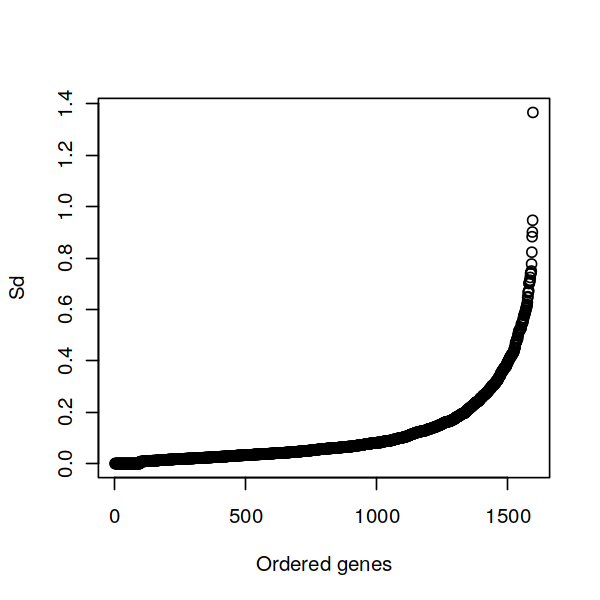

In [5]:
# 1. load data
o(5,5)
goi = alp1.hvg
mat = read.csv('./221112-ABM-aLP1_5to0-PathExpr.csv', row.names = 1)
colnames(mat) <- paste("T",0:(ncol(mat)-1), sep='')
mat = mat[ intersect(goi,rownames(mat)), ]
eset <- new("ExpressionSet",exprs = as.matrix(mat))
eset <- filter.std(eset,min.std=0.04) # filter data
eset <- standardise(eset)

## param est

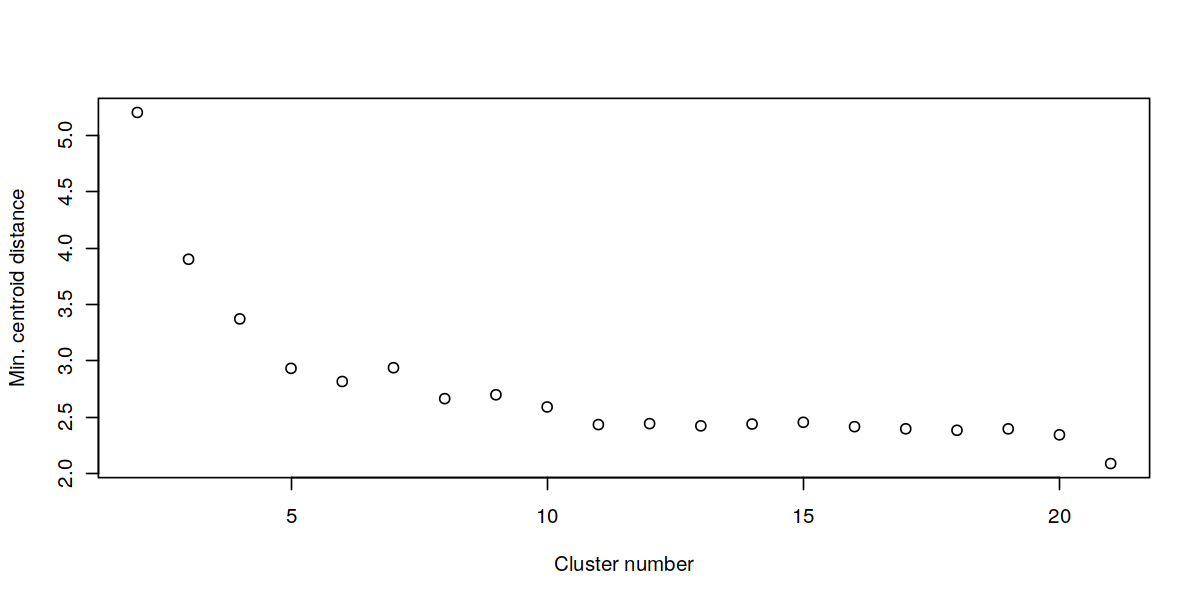

In [6]:
# 2. parameter estimation
m <- mestimate(eset)

# Find minimal distances among cluster centroids
o(10,5)
param.trial <-Dmin(eset, m=m, crange=seq(2,21,1), repeats=5, visu=T)

## do clustering

Warning message:
“Ignoring unknown aesthetics: order”


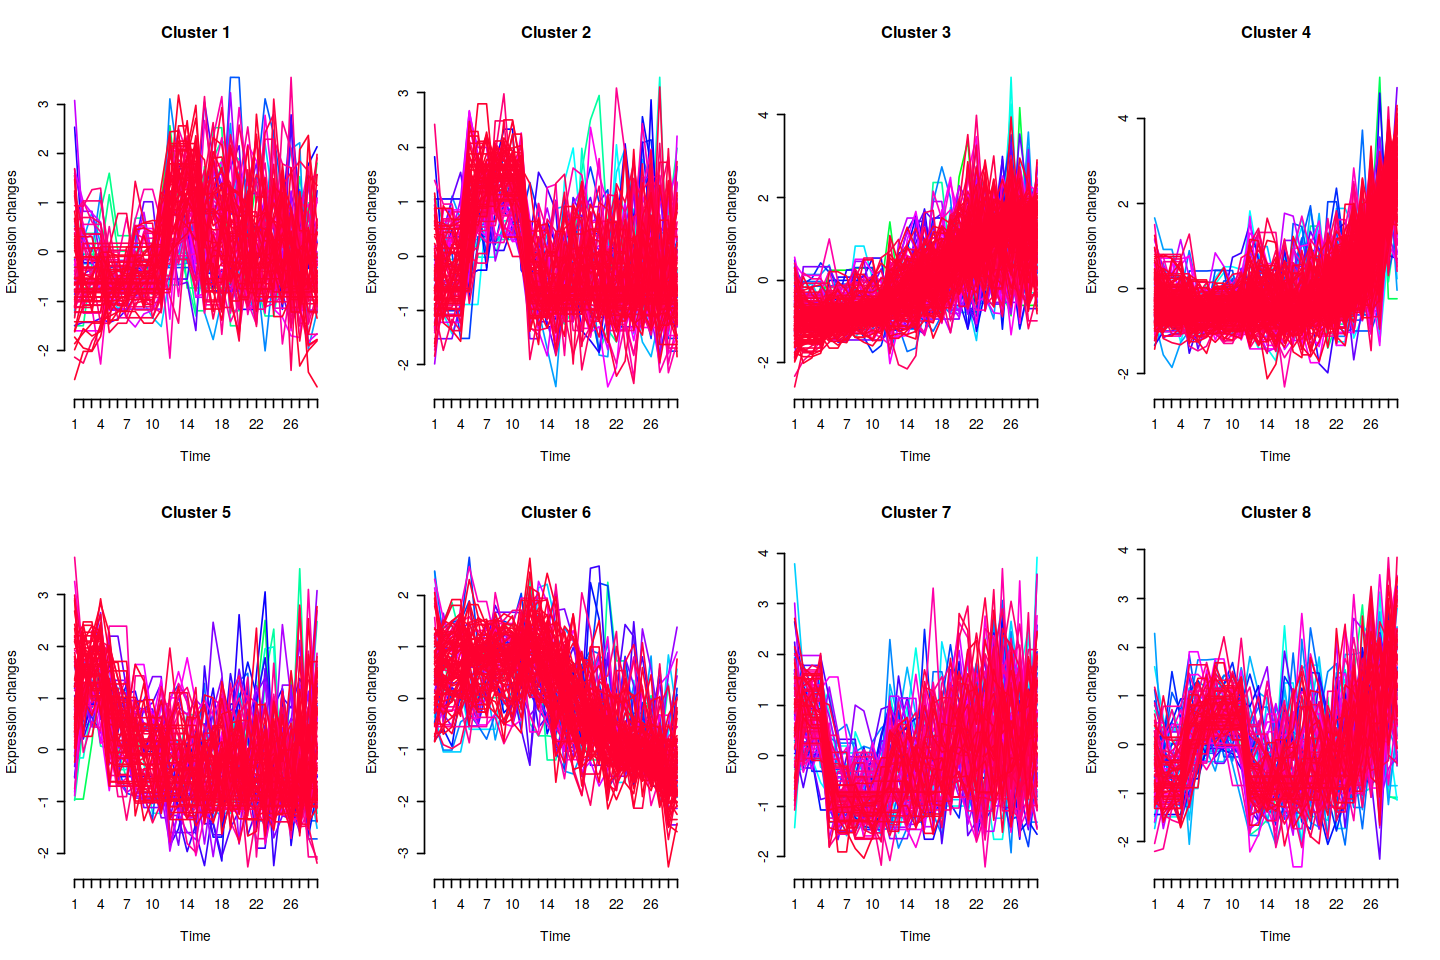

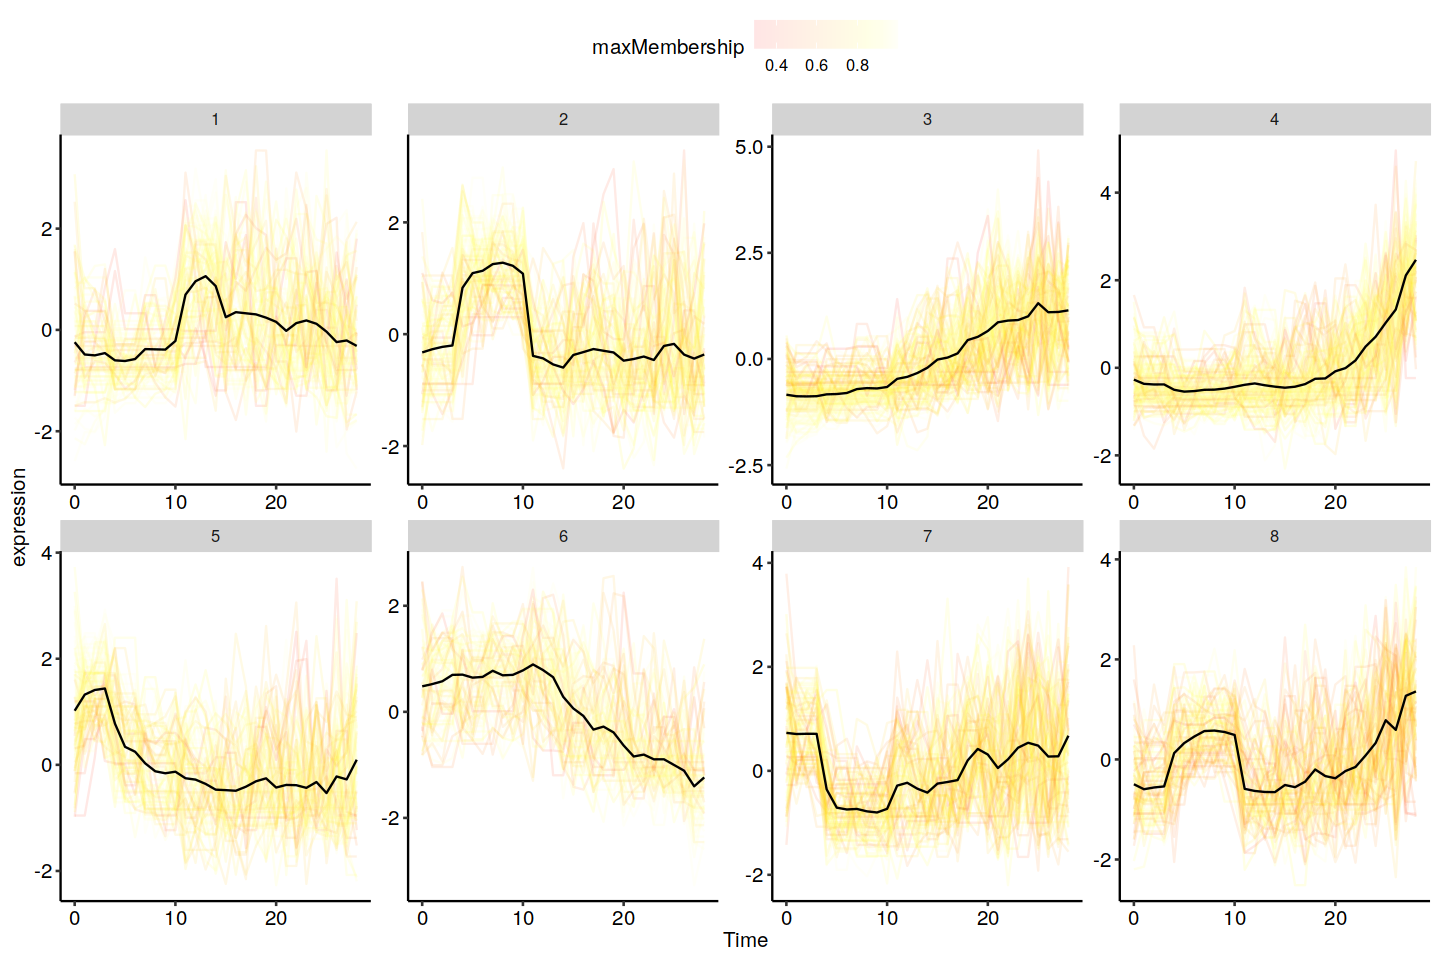

In [9]:
# 3. do clustering and show
c <- 8 # number of clusters
cl <- mfuzz(eset, c = c, m = m) # do clustering

o(3*4,4*2)
mfuzz.plot( eset,cl,mfrow=c(2,4), new.window= FALSE)


o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

In [10]:
# 4. extract cluster information
# find number of genes in each cluster
cl$size

# extract genes within a certain cluster
cluster_gene <- as.data.frame(cl$cluster)
colnames(cluster_gene)<-'GeneCluster'
cluster_gene <- cluster_gene %>% mutate(gene = rownames(.))

# Find gene-cluster memberships
membership   <- cl$membership
colnames(membership) <-paste('BelongToGC',colnames(membership), sep='')
membership <- membership %>% as.data.frame %>% mutate(gene= rownames(.))

[1]  86 104 196 198  92 105 100 103

In [22]:
# 5. explain clusters

get_cluster_genes<- function(membership, cluster, cutoff){
    df = membership[, cluster,drop=F]
    colnames(df) <- 'affinity'
    df <- df %>% filter(affinity>cutoff) %>% arrange(desc(affinity))
    rownames(df)
}


path.enrichment.analysis<- function(pathid) {
    path.gene <- get_cluster_genes(membership, pathid, cutoff = 0.6)
    gene.df    <- bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db)
    enrich.res <- enrichGO(gene= gene.df$ENSEMBL,
                OrgDb         = org.Mm.eg.db,
                keyType       = 'ENSEMBL',
                ont           = "BP",
                pAdjustMethod = "BH",pvalueCutoff  = 0.05,qvalueCutoff  = 0.05)
    enrich.res  <- pairwise_termsim(enrich.res, method="Wang", semData=d)
    enrich.tree <- tryCatch({
        treeplot(enrich.res)
    }, warning = function(warning_condition) {
        print('treeplot failed')
        1}, 
       error = function(error_condition) {
        print('treeplot failed')
        2
    }, finally={-1})
    
    result <- list()
    result[['path.gene']]  <-path.gene
    result[['enrich.res']] <-enrich.res
    result[['enrich.tree']]<-enrich.tree
    return(result)
}

In [23]:
res1 <- path.enrichment.analysis(1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“10.53% of input gene IDs are fail to map...”


[1] "treeplot failed"


In [14]:
res2 <- path.enrichment.analysis(2)
res3 <- path.enrichment.analysis(3)
res4 <- path.enrichment.analysis(4)
res5 <- path.enrichment.analysis(5)
res6 <- path.enrichment.analysis(6)
res7 <- path.enrichment.analysis(7)
res8 <- path.enrichment.analysis(8)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“5.15% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“6.56% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“2.76% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“9.41% of input gene IDs are fail to map...”
'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(path.gene, fromType = "SYMBOL", toType = c("ENSEMBL"), OrgDb = org.Mm.eg.db):
“1.03% of input gene

# Analysis result

Warning message:
“Ignoring unknown aesthetics: order”


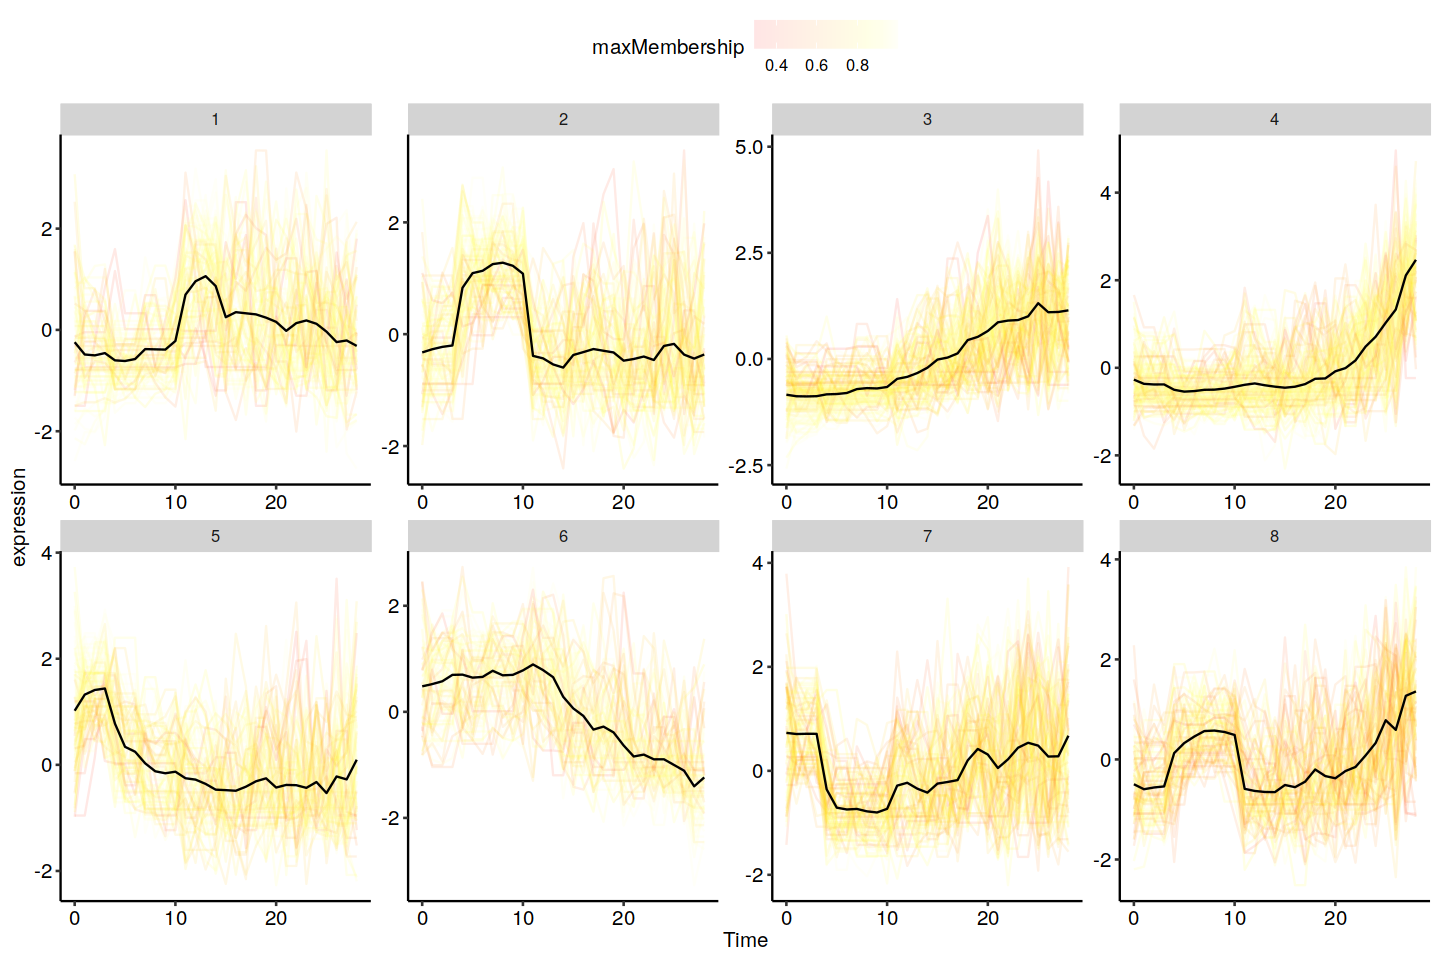

In [24]:
o(3*4, 4*2)
mFuzz.ggplot(eset, cl, centre = T, nrow=2,ncol=4)

## C1

[1] "Genes:"
Hist1h1b Igf1r Zfp85 2810454H06Rik Mmp11 Rrm1 Mir142hg Hist1h1e Txndc16 Cd300lb Sstr2 Agpat3 Anp32b Cd3g Smpdl3a Pclaf Hist1h4i Dusp2 Kat6b Bbs4 Rrm2 Nim1k Anxa1 Hoxa9 Dek Tgtp2 Cers6 Hspa1a Rnf213 Crebrf Gimap9 2900026A02Rik Gpr171 Vangl2 Eya1 Gpr65 Il18rap Stmn1 Slbp Galnt12 Tpm2 Fam129a Tmem176b Abhd14b Dntt Hsh2d Ints2 Gm42418 Gm5086 Tmem80 Pdcd4 Ass1 Gimap6 Dok3 Grhpr Tmem121 Ablim1 Ube2s Pear1 Klrk1 Bcl2 Hist2h2be Ddit3 Rhob Ctsa Egfl7 Ctsw Cd82 Grasp Osbpl7 Ccl9 Irf1 Pbk Tmigd3 Sirpa Capn5NULL
[1] "TFs:"
Zfp85 Hoxa9 Crebrf Eya1 Ddit3 Irf1NULL


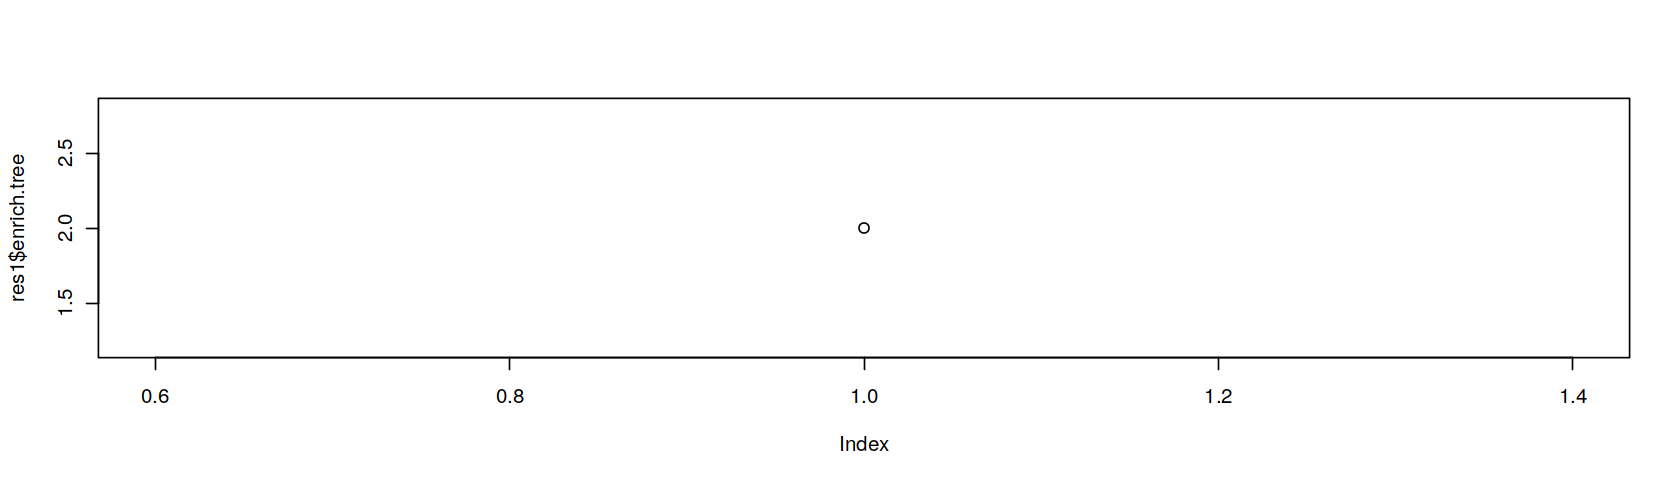

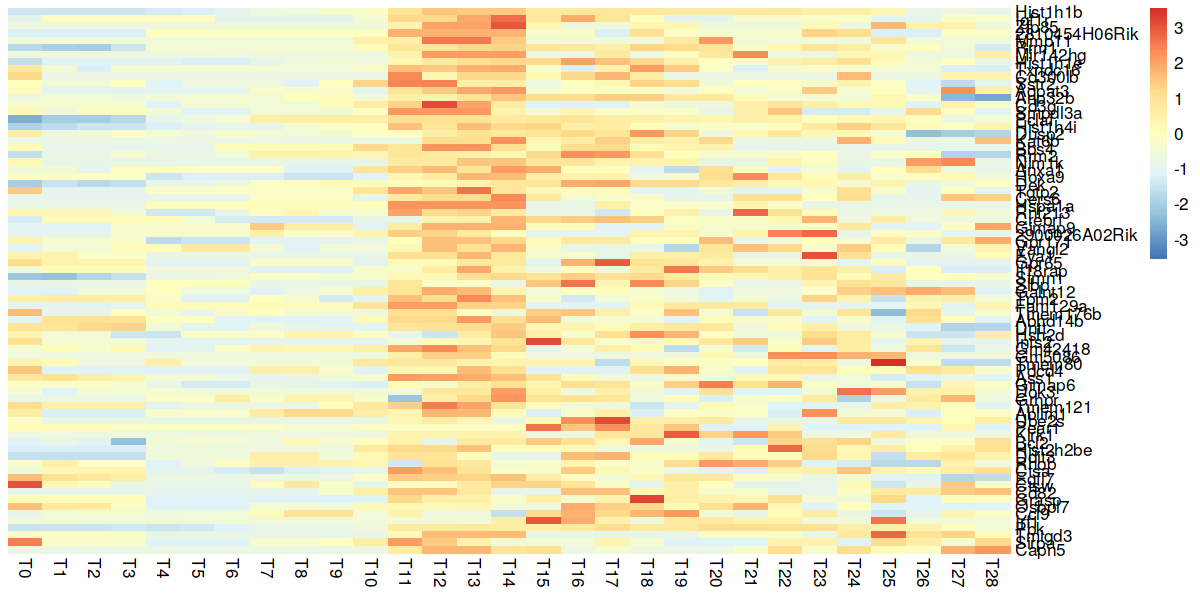

In [25]:
print('Genes:')
print(cat(res1$path.gene))#
print('TFs:')
print(cat(intersect(res1$path.gene, tf)))#

o(14,4)
plot(res1$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res1$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C2

[1] "Genes:"
Tcf7 Ms4a4c Ikzf2 Tmem51 Ap3s1 Fam189b 9230105E05Rik Acp5 Cpne2 Xlr4b Cd63 Dnd1 Plpp5 Id2 Slfn2 Neurl3 Klre1 Spi1 Icos Anxa2 Hp AC153891.1 Kdm6b Rbpms Plxnc1 Lyn 1500011B03Rik Cpa3 Ccl3 Pdlim2 Mycn Itga4 Pi16 Rrm2b Asah1 Wsb2 Mt1 Ctsg Mid1ip1 Cacna2d4 Plcl2 Trim8 Hpse Fdps Nfil3 Pim1 Ms4a4b Gm47230 Gm5914 Trf Rubcn Rgs2 Gyg Gata3 Junb Nrgn Nfkbia Cd96 BC147527 Fam43a Rgs10 Rnasel Cyp4f18 Pdia5 Slc8b1 Cfp Mcm4 Ccdc122 Tapbp 1110008P14Rik Glipr1 Ier2 Eva1b Fam46a Isoc2b Basp1 Cdkn1a Smox Cldnd1 Tspyl2 Fosb Fam105a Xaf1 Cd84 Ccl6 Endov Atp4a Klrb1f Cd6 Cyp51 Exoc1 Tnni1 Abcb4 Gpr137 Zcchc18 Cdk8 Tbc1d14NULL
[1] "TFs:"
Tcf7 Ikzf2 Id2 Spi1 Kdm6b Mycn Nfil3 Gata3 Junb Nfkbia FosbNULL


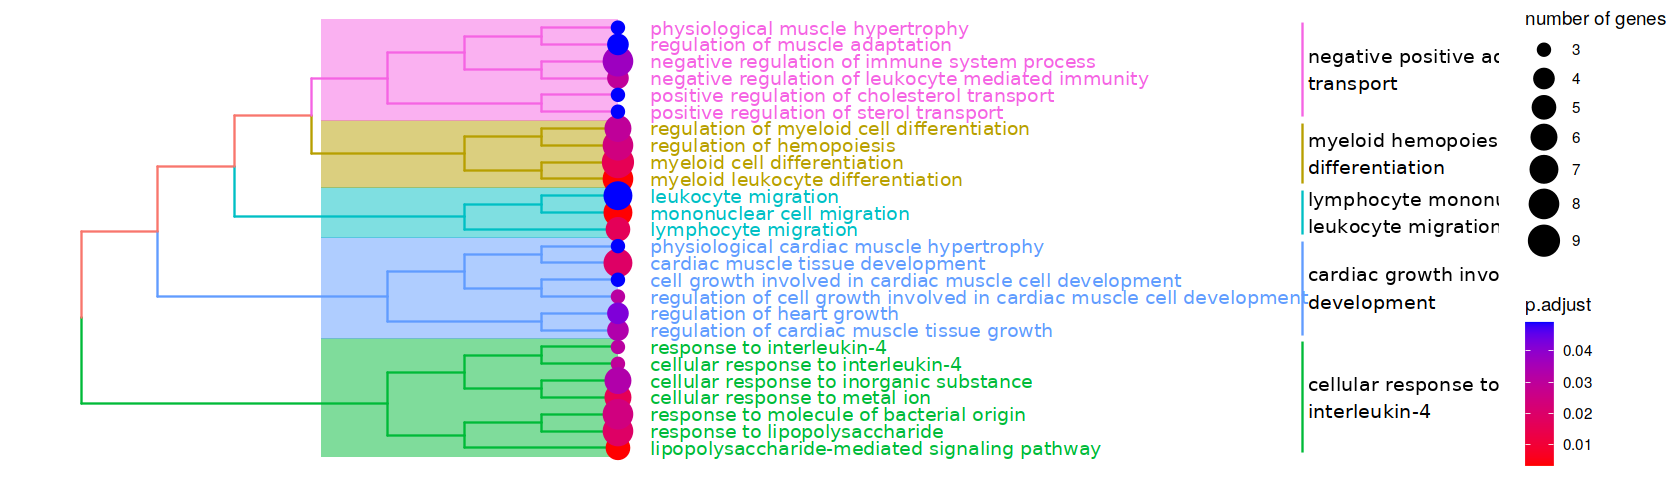

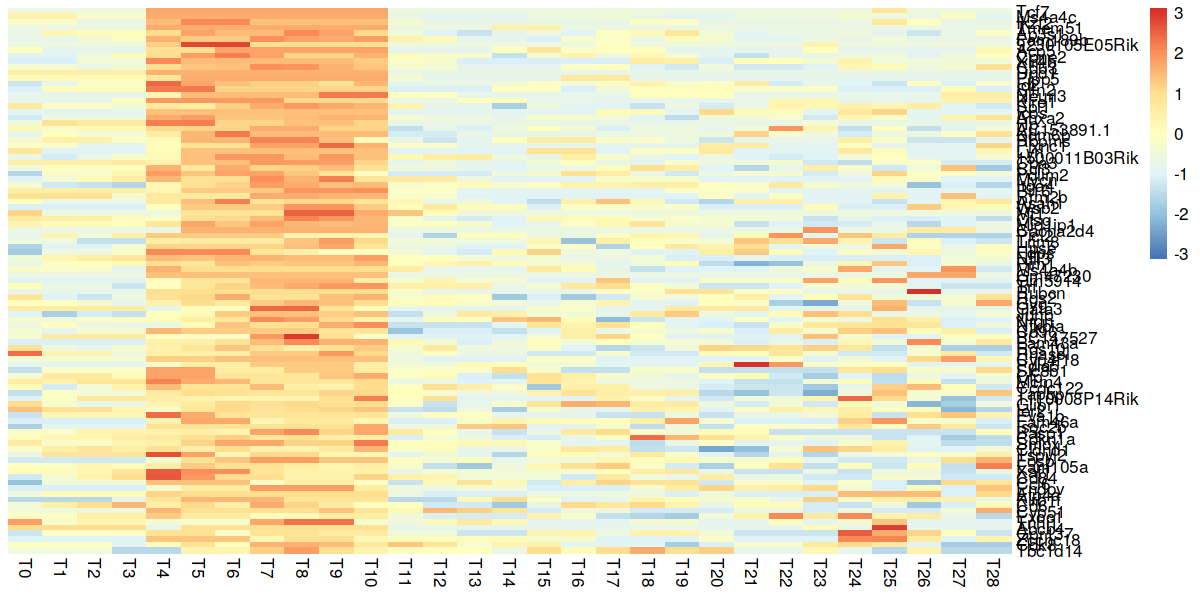

In [27]:
print('Genes:')
print(cat(res2$path.gene))#
print('TFs:')
print(cat(intersect(res2$path.gene, tf)))#

o(14,4)
plot(res2$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res2$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C3

[1] "Genes:"
Plk1 Cks2 Calm2 Kif22 H2afv Mxd3 Incenp Ckap2l Aurka Racgap1 H2afx Ccnb2 Anp32e Nucks1 Cdca3 Hmgb2 Nusap1 Fzr1 Ccnd3 Lmnb1 Tpx2 Cenpe Smc4 Aurkb Hmgn2 Tubb5 Top2a Prc1 Hmmr Cenpa Kif11 Birc5 Cenpf Mki67 Tmpo Cdca8 Neil3 Cdkn2d Shcbp1 Smc2 Tubb4b Spc25 Ighm Cdk1 Arl6ip1 Sgo1 Ccna2 Bub3 Spc24 H2afz Tpm4 Cdc20 Fbxo5 Kif20a Tmem119 H1fx Ncapd2 Lockd Mis18bp1 Cdkn2c Tuba1c Vim Hoxa7 Sat1 Nudt18 Smad7 Gna15 Tecpr1 Hes6 Ccnf Rbm47 Kifc1 Sox4 Kif20b Clic4 Ccnb1 Kif2c Pimreg Notch1 Fcer1g H1f0 Tacc3 Sdc1 Clec12a Jakmip1 Gm28707 Cks1b Ezh2 Slc44a2 Dlgap5 Mycl Tsc22d1 St3gal6 Jpt1 Acadm Snx9 Ube2c Plk4 2310001H17Rik Klf7 1500009L16Rik Gapt Ly86 Kif21b Tmem86a Nde1 Shisa2 Hist1h2ac Gadd45a Gm10138 Arpp21 Asf1b Hist1h2ae Cnn3 1700097N02Rik Aaed1 Inpp5f Ppp1r16b Syk Prkca Gimap4 Pik3ip1 Ankfy1 Mindy2 Kpna2 Nfkbie Cst3 Tmed3 Tet1 Cd3d Cdkn3 Lztfl1 Paip2b Blnk Tuba1b Itm2c Tifab Abhd17b Rhobtb2 Mmp15 H2-D1 Bambi Rgl1 Vegfc Calcoco1 Rai2 Havcr2 Blvrb Zeb2os Maml2 Clec2d P2rx4 H2-T23 Irf8 Y

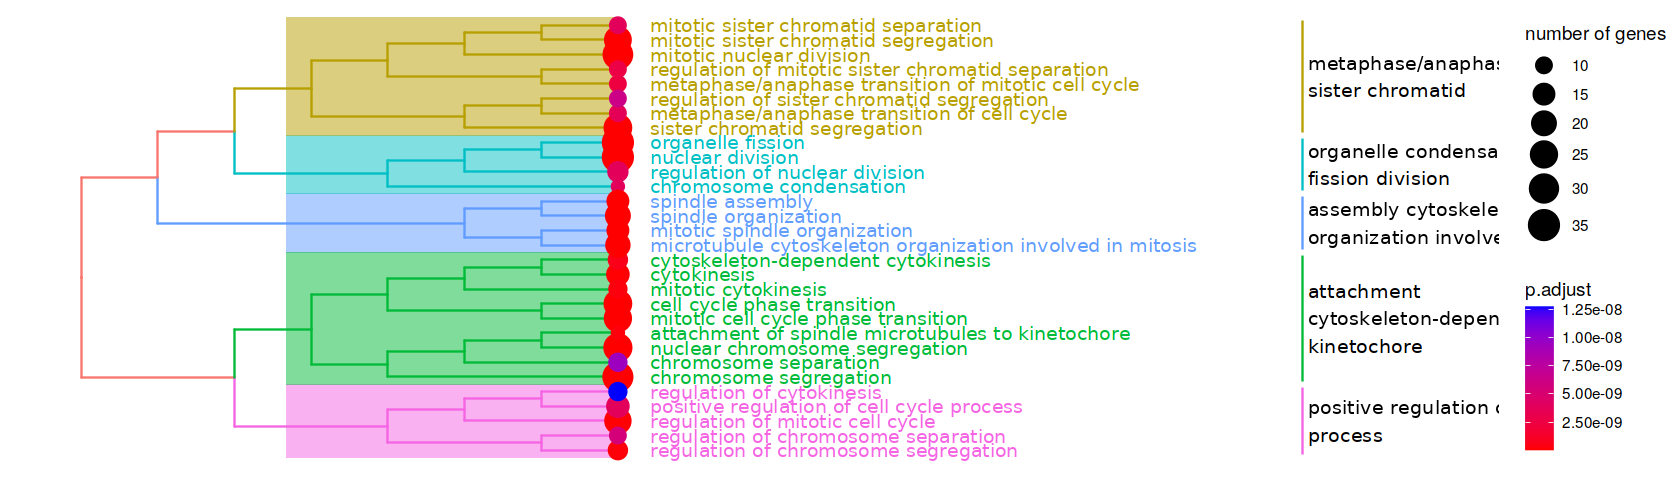

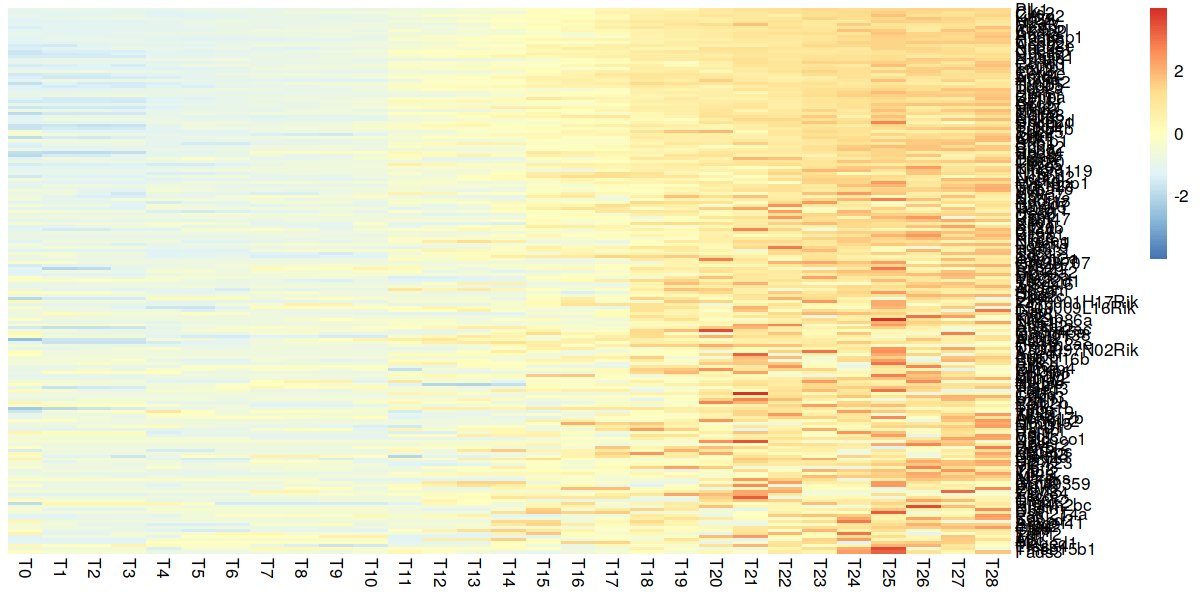

In [28]:
print('Genes:')
print(cat(res3$path.gene))#
print('TFs:')
print(cat(intersect(res3$path.gene, tf)))#

o(14,4)
plot(res3$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res3$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C4

[1] "Genes:"
Ptms Nucb2 Cd7 Grn Bst2 Siglech Klrd1 Fgr Rnase6 Fyb Hvcn1 Psap Scpep1 Atp1b1 Emp1 Tbc1d4 Snx18 Cdh5 Ldlr Aldh3b1 Arl5c Ap3m2 Spib Ccr9 Ctsl Rnf122 Lsp1 Ptgr1 Zc3h6 Fyn Them6 Robo3 Tnfaip8l2 Ly6d Sdc4 Unc93b1 Gsn Mzb1 Hmgn3 Cyth4 Sp140 Serp1 Hs3st1 Cybb Tex2 Tfrc Ifi27l2a Gbp8 Tubb2a Smim5 Plin3 Lynx1 Pld4 Blk Spp1 Lmo4 Jaml Gpr132 Reep4 Havcr1 Itgax Rab33b Cd72 Upb1 Lair1 Vps37a Cd300c Mvb12a S100a6 Plp2 Ctsh Cd68 Selplg Net1 Slamf6 Ctss Ly6c2 St6gal1 Tmem71 Nrp1 Btg2 Arid3a Xbp1 Dnajc7 Trim30a Psrc1 Hsp90b1 Trim12a Slc29a3 Lpin1 Rsrp1 Tpd52 Mta3 Sec24d Clec2i Tbc1d8 Stoml1 Tnfrsf13b Pacsin1 Nek2 Trp53i11 Slc2a6 Nedd9 Hist3h2ba Klf13 Sh2d3c Klf2 Ly6e Anxa6 H2-K1 Lgals3 Hmgb3 Tbxa2r Sell Inpp4a Eepd1 Orai2 Fcrla Thy1 Gpr18 Jund Paqr5 Tsc22d3 B930036N10Rik Itgb2 Cnp Tubgcp5 Gm14302 Cit Lpgat1 Fbxo6 Lag3 Cd9 Anxa5 Adora2a Alcam Spata13 Mpeg1 Ubl3 Wnt10b Fstl3 Pmepa1 Slpi Padi1 Stambpl1 Btg1 Tspan13 Bcl11a Capg Lifr Epha2 Pqlc3 Stk17b Fam160b1 Mctp2 Syne2 Cox6a2 Ppfia4 St8sia

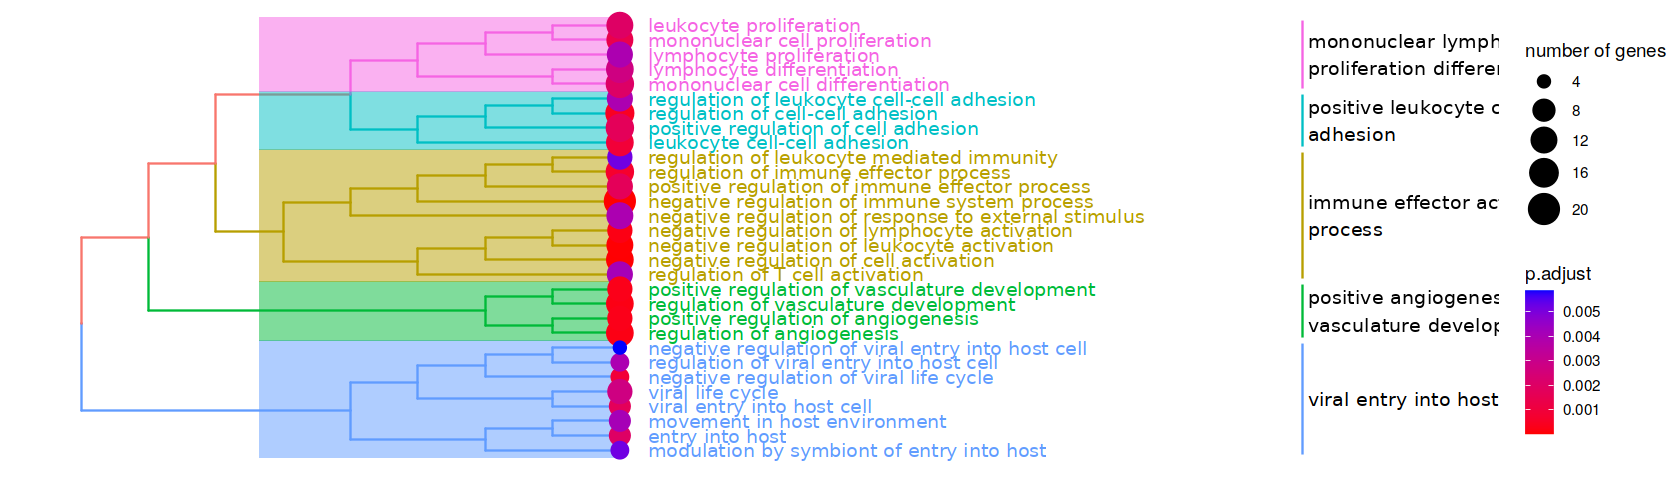

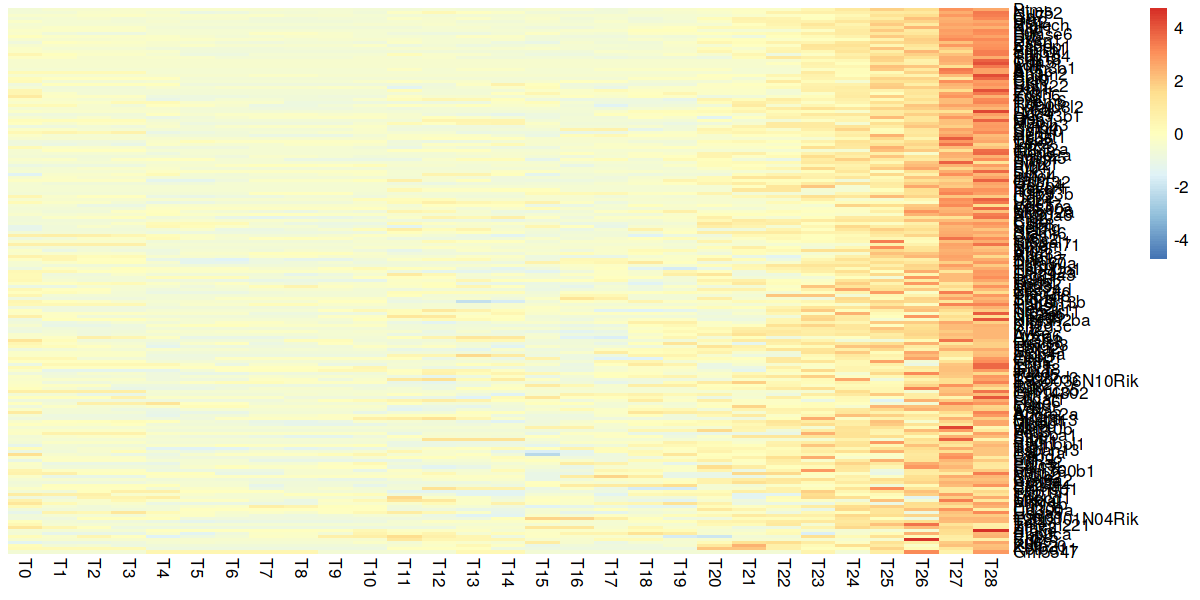

In [29]:
print('Genes:')
print(cat(res4$path.gene))#
print('TFs:')
print(cat(intersect(res4$path.gene, tf)))#

o(14,4)
plot(res4$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res4$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C5

[1] "Genes:"
Vasp Mr1 Klhdc1 Trim68 Mgst2 Furin Gm19590 AA467197 Pik3r5 Zfp942 Apobec1 Notch2 Dhx58 Tep1 Rhbdf2 Il18r1 Akr1c13 Lax1 Jchain Comt Socs1 Gm19331 Gm16124 Tmem141 Ogt Lpar6 Gstt2 Nek6 Dkkl1 H2-Aa Cd24a Bcl3 Ifitm1 Gcnt2 Lgals8 Ccnd1 Tspan32 H2-Eb1 Cd33 Paip1 Sytl1 Cebpd Gmcl1 Emb Ifnar1 Sqle Epsti1 Cdk6 Mfsd6 Pnck H2afy Gata2 H2-DMa Ms4a6b Zfp992 Irf7 H2-Ab1 Fgd2 Gm17259 Gm2a Hmga2 Gfod2 Rtp4 Camk2a Rpgrip1 Ifitm3 Tmc8 Alox5ap Ahdc1 Fbxl17 D730003I15Rik Gm15261 Lppos Ccl4 Msmo1 Eif2ak2 Gm47754 Napsa Padi2 Hcst Dtx3l Mn1 2610035D17Rik Brdt Ppp3ccNULL
[1] "TFs:"
Zfp942 Notch2 Bcl3 Ccnd1 Cebpd Gata2 Zfp992 Irf7 Hmga2 Eif2ak2NULL


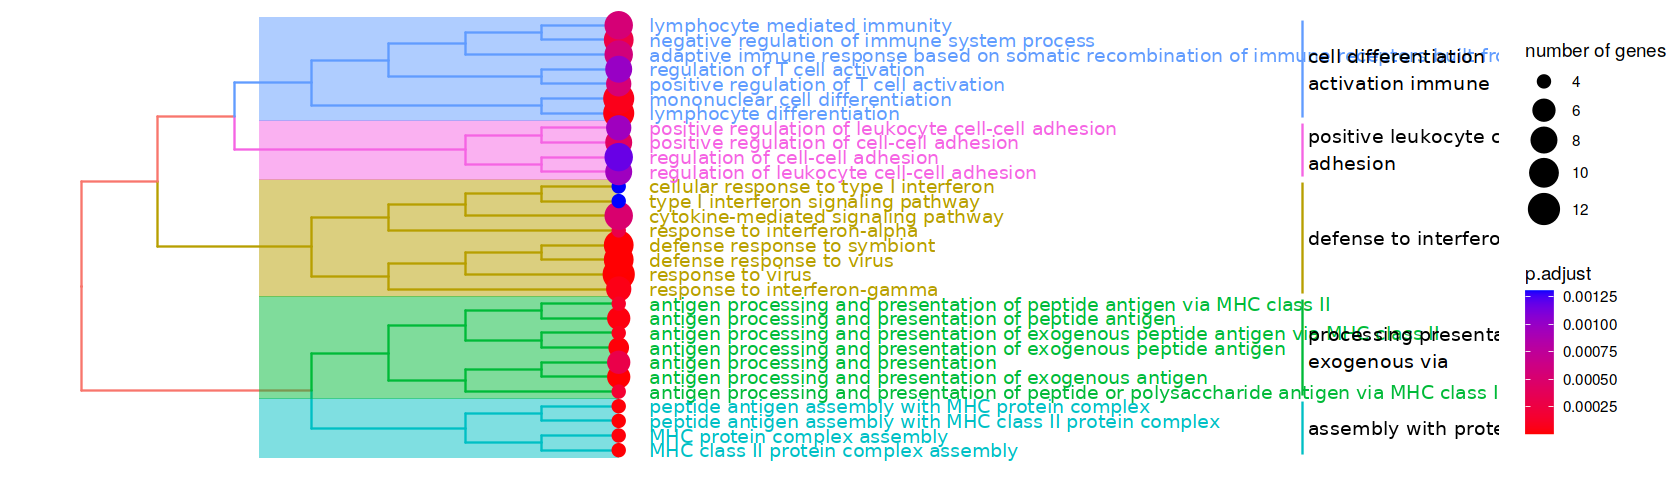

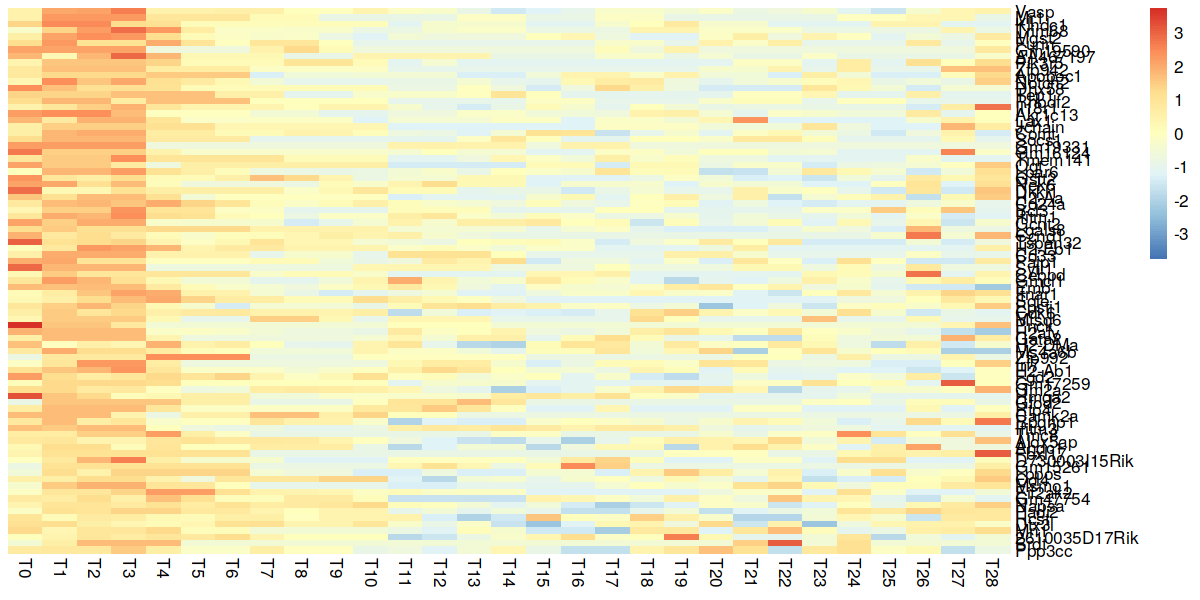

In [30]:
print('Genes:')
print(cat(res5$path.gene))#
print('TFs:')
print(cat(intersect(res5$path.gene, tf)))#

o(14,4)
plot(res5$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res5$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C6

[1] "Genes:"
Mif Dut Cd34 Ranbp1 Mcm6 Pcna Mcm3 Cdca7 Marcksl1 Mcm5 Srm Nasp Hells Ncl Tipin Rpa2 Lig1 Ldha Mcm7 Calr Dhfr Mcm2 Uhrf1 Syce2 Ctr9 Mpo Nkg7 Ran Cycs Il6ra Pola2 Ccne2 Dtl Cd52 Tmem108 Ctla2a Ifitm2 Tuba4a Serpinf1 Myl10 E2f1 Ncf4 Tk1 Gm47283 Prtn3 Ccnd2 Gmnn Pou2f2 Ifi27 Atad2 P2ry14 Usp37 Dpp4 Aldoa Ccne1 Dok2 Myc Fabp5 Acvr2b Ift57 Pds5b Shisa8 Slc35d3 Cdv3 Acot1 N4bp2l1 C1qtnf12 Clspn H2-DMb2 Tyms Tox H2-Oa Igfbp4 H2-Ob Wfdc17 Gfi1b Iigp1 Acsl1 Ptpre Xlr3b Ung Phlda1 Serpina3g Cd81 Crip1 Cebpb Csf1r Car2 Lpcat2 Ldhb Izumo4 Pbxip1 Gstm5 Ctsc Ier3 Ltb4r1 Ppm1lNULL
[1] "TFs:"
Mcm6 Mcm3 Ctr9 E2f1 Pou2f2 Myc Tox Gfi1b CebpbNULL


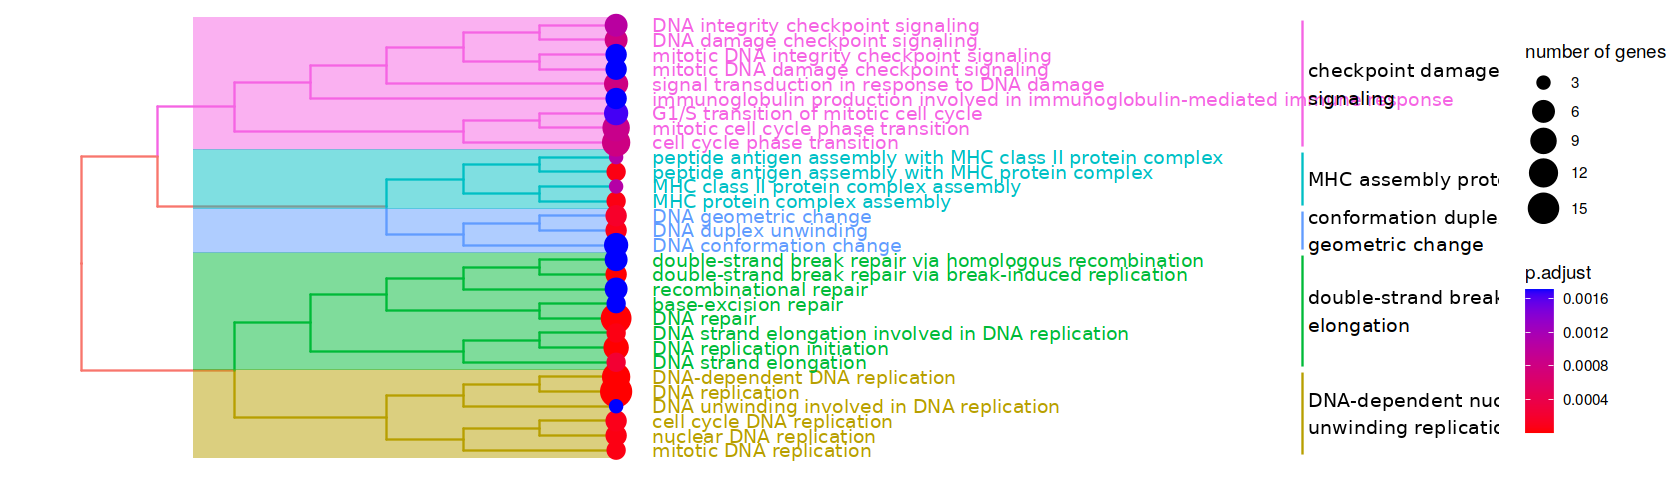

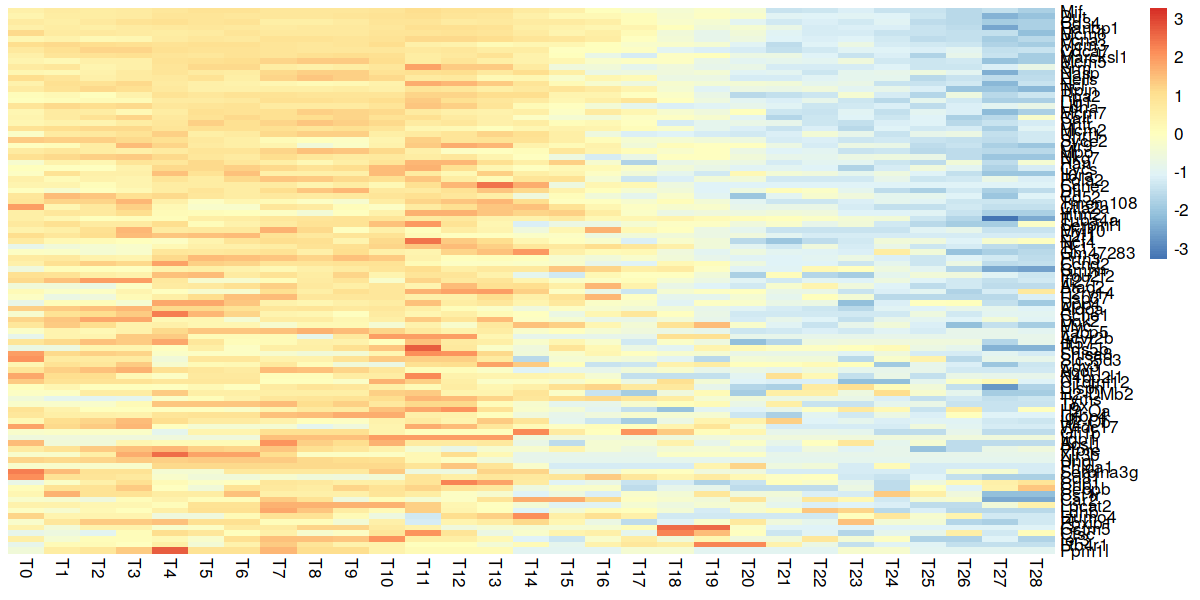

In [31]:
print('Genes:')
print(cat(res6$path.gene))#
print('TFs:')
print(cat(intersect(res6$path.gene, tf)))#

o(14,4)
plot(res6$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res6$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C7

[1] "Genes:"
Arhgef3 Fth1 Tnfrsf13c Hmgcs1 Il21r Srebf2 Smarca2 Themis2 Gm14161 Eps15 Card11 Lmo2 AC147041.1 Grina Ncoa3 Il12a Cmah Cd69 Hbb-bs Il10ra Zfp36l1 Npc1 Inafm2 Tmem63a Naga Csf2ra Txnip Xrcc6 Ets1 Cyp4f13 Gimap5 Nlrc3 Tmem176a Klf3 Tle1 Tlr7 Ehbp1l1 Evl Lgmn Dusp22 Wfs1 Dlgap4 Gm11579 Shisa5 4930481A15Rik Cyp2j6 Rhoh Rgs1 Fbxl4 Ctso Fam174a Cd27 Noa1 H2-M3 Slc12a9 Chd3 Khk Zeb2 S100a9 Slc39a1 Dirc2 Il7r Zfp945 5031425E22Rik Setd4 4931406C07Rik Xlr4a Hlx A630001G21Rik Kdm5b D830025C05Rik Myl4 Terf2ip Ar Ly6a Ptprs Hk2 Phf21a Serpinb1a Aplp2 Myo1c PkibNULL
[1] "TFs:"
Srebf2 Smarca2 Lmo2 Ncoa3 Zfp36l1 Xrcc6 Ets1 Klf3 Zeb2 Zfp945 Hlx ArNULL


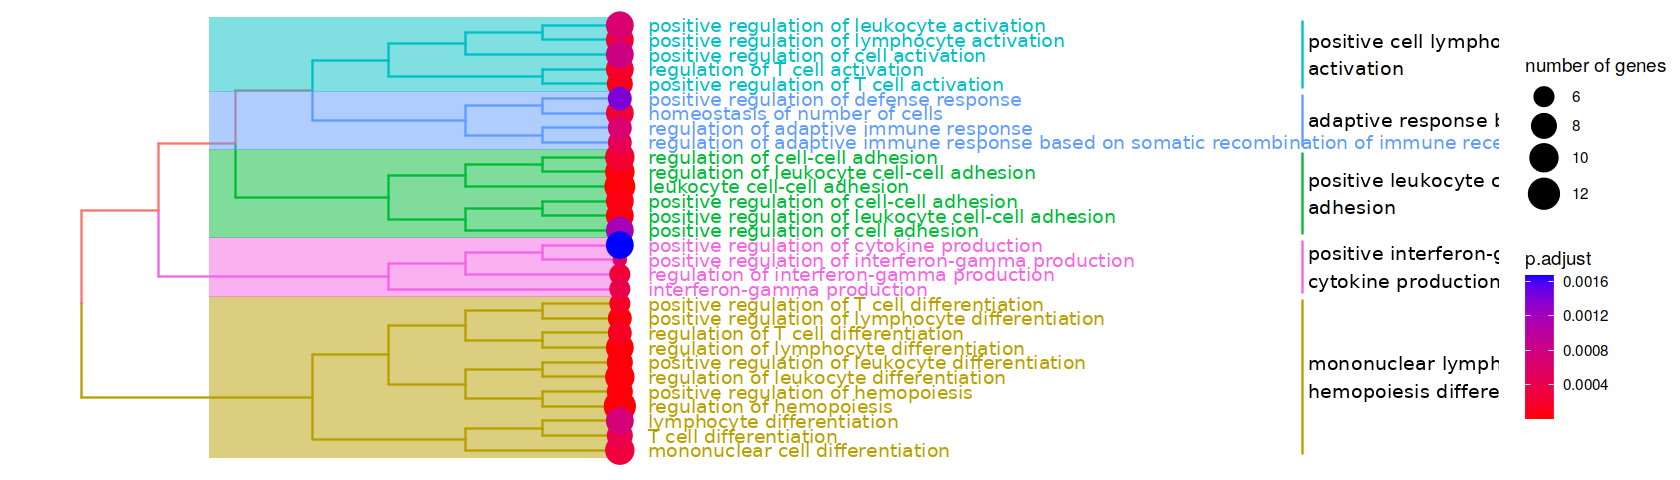

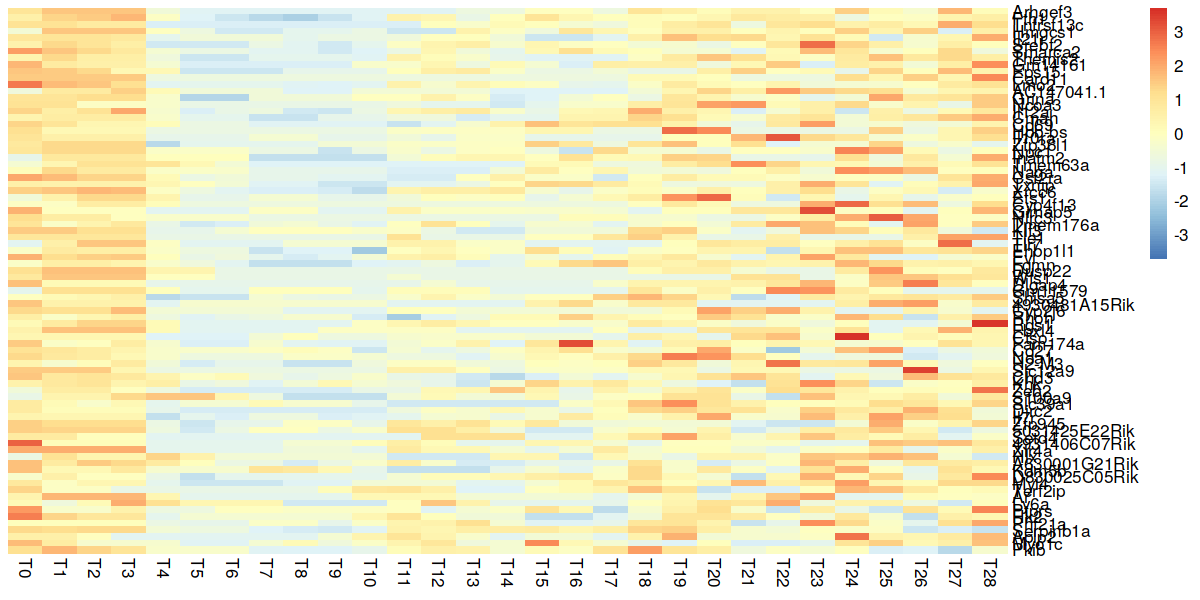

In [36]:
print('Genes:')
print(cat(res7$path.gene))#
print('TFs:')
print(cat(intersect(res7$path.gene, tf)))#

o(14,4)
plot(res7$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res7$path.gene,], scale = 'row', #
         cluster_rows = F, cluster_cols = F, border_color=NA)



## C8

[1] "Genes:"
Itgb7 Cnn2 Gadd45b Rassf4 Tyrobp Kmo Siglecg Skil Ier5 Pml Gm42722 Selenos Stx7 Dnajb9 Tcta Clcn5 Xpr1 Fam117b Stat2 Neat1 Ifi209 Atp1a3 Trim5 S100a11 Cyba Bmp2k Kctd14 Stat1 Mxd4 Lck Ccl5 Ctsz Nfkbiz I830077J02Rik Slc25a53 Gpr146 S100a8 Icam1 Dnajb14 Bach2 Sp100 B4galt5 Mcpt8 Rrad Jun Vsir Abi3 Myh9 Pkig Gngt2 Nfkbid Unc13d Insig1 Pdk2 Cytip Sla2 Slc43a2 Manf Trim30d Rell1 Fbrsl1 Nfkb1 Ppp1r15a Timp2 Blcap Gpcpd1 H2-Q7 Auts2 B3gnt8 Pkp3 Zfp36 Kctd12 Ahnak Ctnnd2 Ifi35 Ms4a6c Arid5b Trbc2 Dusp1NULL
[1] "TFs:"
Skil Pml Stat2 Stat1 Mxd4 Nfkbiz Bach2 Sp100 Jun Sla2 Nfkb1 Zfp36 Arid5bNULL


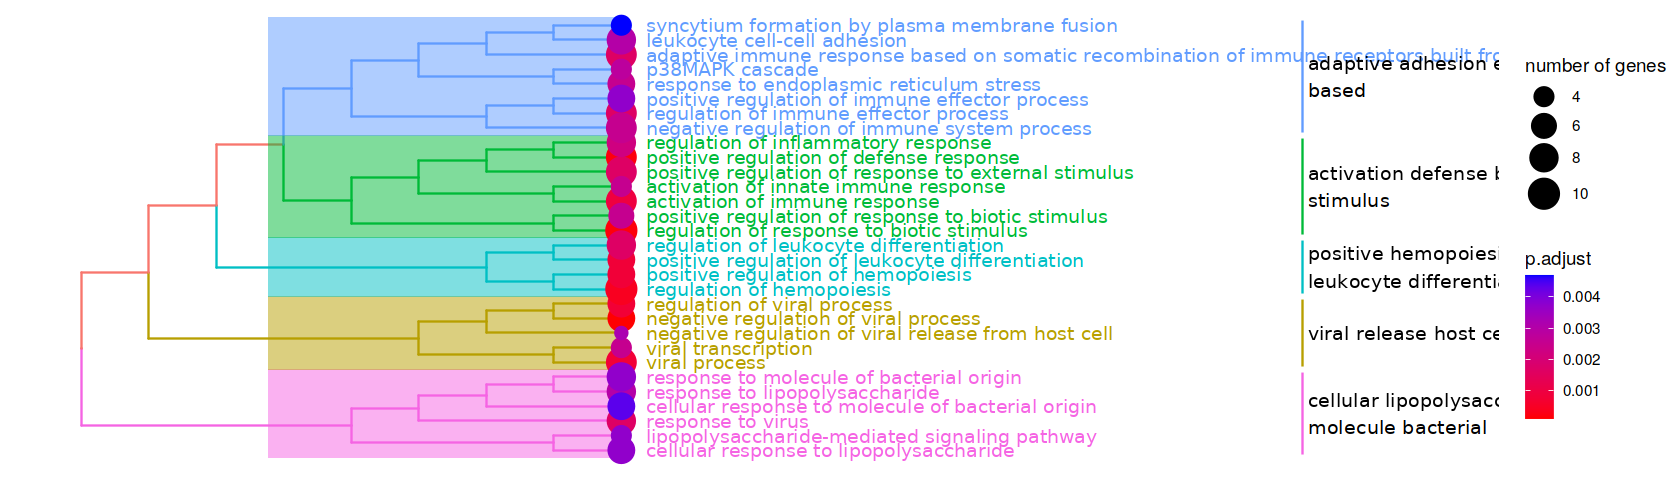

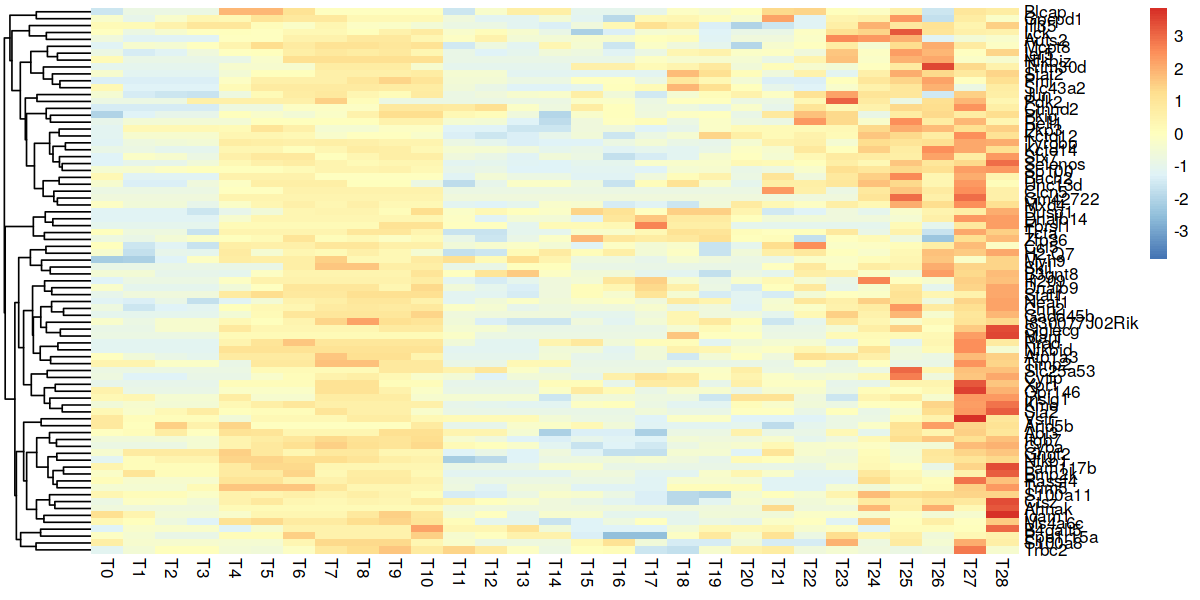

In [34]:
print('Genes:')
print(cat(res8$path.gene))#
print('TFs:')
print(cat(intersect(res8$path.gene, tf)))#

o(14,4)
plot(res8$enrich.tree)#

library(pheatmap)
o(10,5)
pheatmap(mat[res8$path.gene,], scale = 'row', #
         cluster_rows = T, cluster_cols = F, border_color=NA)

